## This notebook is used for testing pytorch dataset and dataloader

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used
import warnings
warnings.filterwarnings("ignore")

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

### Dataset

In [3]:
class PandaPatchDataset(Dataset):
    """Panda Tile dataset. With fixed tiles for each slide."""
    def __init__(self, csv_file, image_dir, N = 12, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            image_dir (string): Directory with all the images.
            N (interger): Number of tiles selected for each slide.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.train_csv = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform
        self.N = N

    def __len__(self):
        return len(self.train_csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        fnames = [os.path.join(self.image_dir, self.train_csv.loc[idx, 'image_id']+'_'+str(i)+'.png') 
                  for i in range(self.N)]
        imgs = [self.open_image(fname)
               for fname in fnames]
        isup_grade = self.train_csv.loc[idx, 'isup_grade']

        if self.transform:
            imgs = [self.transform(img) for img in imgs]
        ## convert the output to tensor
        imgs = [torch.tensor(img) for img in imgs]
        imgs = torch.stack(imgs)
        isup_grade = torch.tensor(isup_grade)
        sample = {'image': imgs, 'isup_grade': isup_grade}
        return sample
    def open_image(self, fn, convert_mode='RGB', after_open=None):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
            x = Image.open(fn).convert(convert_mode)
        if after_open: 
            x = after_open(x)
        return x

In [4]:
def data_transform(mean = (0.5,0.5,0.5), std = (0.5,0.5,0.5)):
    tsfm = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.RandomVerticalFlip(),
         transforms.RandomAffine(degrees=180, fillcolor=(255, 255, 255)),
         transforms.ToTensor(),
         transforms.Normalize(mean=mean,
                              std=std)])
    return tsfm

def dataloader_collte_fn(batch):
    imgs = [item['image'] for item in batch]
    imgs = torch.stack(imgs)
    target = [item['isup_grade'] for item in batch]
    target = torch.stack(target)
    return [imgs, target]

In [5]:
nfolds = 5
bs = 4
csv_file = './panda-16x128x128-tiles-data/{}_fold_train.csv'.format(nfolds)
image_dir = './panda-16x128x128-tiles-data/train/'
mean = torch.tensor([0.5, 0.5, 0.5])
std = torch.tensor([0.5, 0.5, 0.5])
# mean = torch.tensor([0.90949707, 0.8188697, 0.87795304])
# std = torch.tensor([0.36357649, 0.49984502, 0.40477625])

In [6]:
tsfm = data_transform(mean, std)
dataset = PandaPatchDataset(csv_file, image_dir, transform = tsfm)
sample = dataset[0]
print(len(sample['image']), sample['isup_grade'])

12 tensor(0)


### Dataloader

In [7]:
dataloader = DataLoader(dataset, batch_size=bs,
                        shuffle=True, num_workers=4, collate_fn=dataloader_collte_fn)

In [8]:
img, target = iter(dataloader).next()
print("image size:{}, target sise:{}.".format(img.size(), target.size()))

image size:torch.Size([4, 12, 3, 128, 128]), target sise:torch.Size([4]).


### Plot data batch

In [9]:
grid = utils.make_grid(img[0], nrow = 12, normalize = True) # normalize map image back to [0, 1]

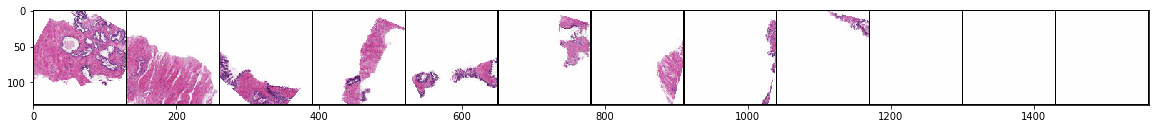

In [10]:
plt.figure(figsize = (20,300))
plt.imshow(grid.numpy().transpose((1, 2, 0)))

### Using cross validation

In [12]:
class crossValInx(object):
    def __init__(self, csv_file):
        self.crossVal_csv = pd.read_csv(csv_file)

    def __call__(self, fold = 0):
        val_idx = self.crossVal_csv.index[self.crossVal_csv['split'] == fold].tolist()
        train_idx = list(set([x for x in range(len(self.crossVal_csv))]) - set(val_idx))
        return train_idx, val_idx

In [27]:
idxSplit = crossValInx(csv_file)
train_idx, val_idx = idxSplit(3)

In [28]:
train = torch.utils.data.Subset(dataset, train_idx)
val = torch.utils.data.Subset(dataset, val_idx)

In [36]:
trainloader = torch.utils.data.DataLoader(train, batch_size=bs, shuffle=True, num_workers=0, collate_fn=dataloader_collte_fn, pin_memory=True)
valloader = torch.utils.data.DataLoader(val, batch_size=bs, shuffle=True, num_workers=0, collate_fn=dataloader_collte_fn, pin_memory=True)

In [37]:
img, target = iter(trainloader).next()

In [39]:
print("image size:{}, target sise:{}.".format(img.size(), target.size()))

image size:torch.Size([4, 12, 3, 128, 128]), target sise:torch.Size([4]).
